In [9]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications.xception import preprocess_input, decode_predictions
import random
import h5py


%matplotlib inline

In [4]:
os.chdir('D:/Machine Learning/dogs_vs_cats-master')

In [6]:
os.getcwd()

'D:\\Machine Learning\\dogs_vs_cats-master'

In [7]:
# 建立符号链接
def data_symbol_link():
    work_dir  = os.getcwd()
    train_dir = work_dir + "\\train\\"
    test_dir  = work_dir + "\\test\\"
    data_dir  = work_dir + "\\data\\"
    
    if(os.path.exists(data_dir)):
        shutil.rmtree(data_dir)
        
    split_train_dir = work_dir+"\\data\\train"
    split_test_dir  = work_dir+"\\data\\test"
    os.mkdir(data_dir)
    
    os.mkdir(split_train_dir)
    os.mkdir(split_train_dir+"\\dog")
    os.mkdir(split_train_dir+"\\cat")
    os.mkdir(split_test_dir)
    os.mkdir(split_test_dir+"\\test")
        
    train_files = os.listdir(train_dir)    
    num_train_files = len(train_files)
    for i in tqdm(range(num_train_files)):
        file = train_files[i]
        if "dog" in file.split('.'):
            os.symlink(train_dir+file, split_train_dir+"\\dog\\"+file)
        else:
            os.symlink(train_dir+file, split_train_dir+"\\cat\\"+file)
    
    test_files = os.listdir(test_dir)    
    num_test_files = len(test_files)
    for i in tqdm(range(num_test_files)):
        file = test_files[i]
        os.symlink(test_dir+file, split_test_dir+"\\test\\"+file)
        
    return split_train_dir, split_test_dir    

In [10]:
train_data, test_data = data_symbol_link()

100%|██████████████████████████████████████████████████████████████████████████| 12500/12500 [00:02<00:00, 4210.47it/s]


In [11]:
# 构建网络
from sklearn.utils import shuffle
np.random.seed(42)

X_train = []
X_test = []

for filename in ["../features/feature_xception.h5", "../features/feature_densenet201.h5", "../features/feature_inception_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        Y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, Y_train = shuffle(X_train, Y_train)

In [42]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [27]:
# 建立调参训练函数
def train_model(dropout, optimizer):
    input_tensor = Input(X_train.shape[1:])
    x = Dropout(dropout)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    filepath=f"model_weights/{optimizer}_{dropout}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    callbacks_list = [checkpoint]
    history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
             callbacks=callbacks_list)
    model.save_weights(f"model_weights/{optimizer}_{dropout}.h5")
    return model

In [28]:
def train_predict_model(dropout, optimizer):
    model = train_model(dropout, optimizer)
    model.load_weights(f"model_weights/{optimizer}_{dropout}.h5")
    y_pred = model.predict(X_test, verbose=1)
    y_test = y_pred.clip(min=0.005, max=0.995)
    df = pd.read_csv("sample_submission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(test_data, (224, 224), shuffle=False, 
                                             batch_size=16, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
        df.set_value(index-1, 'label', y_test[i])

    df.to_csv(f'submission/{optimizer}_{dropout}.csv', index=None)

In [29]:
train_predict_model(0.5, 'adadelta')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 37s - loss: 0.9305 - acc: 0.37 - ETA: 9s - loss: 0.5732 - acc: 0.6937 - ETA: 5s - loss: 0.4361 - acc: 0.802 - ETA: 4s - loss: 0.3535 - acc: 0.854 - ETA: 3s - loss: 0.2998 - acc: 0.884 - ETA: 3s - loss: 0.2612 - acc: 0.905 - ETA: 3s - loss: 0.2332 - acc: 0.918 - ETA: 2s - loss: 0.2130 - acc: 0.927 - ETA: 2s - loss: 0.1955 - acc: 0.934 - ETA: 2s - loss: 0.1823 - acc: 0.940 - ETA: 2s - loss: 0.1690 - acc: 0.945 - ETA: 2s - loss: 0.1587 - acc: 0.949 - ETA: 1s - loss: 0.1494 - acc: 0.952 - ETA: 1s - loss: 0.1411 - acc: 0.955 - ETA: 1s - loss: 0.1342 - acc: 0.958 - ETA: 1s - loss: 0.1278 - acc: 0.960 - ETA: 1s - loss: 0.1231 - acc: 0.962 - ETA: 1s - loss: 0.1177 - acc: 0.964 - ETA: 1s - loss: 0.1130 - acc: 0.966 - ETA: 1s - loss: 0.1087 - acc: 0.967 - ETA: 1s - loss: 0.1055 - acc: 0.968 - ETA: 1s - loss: 0.1018 - acc: 0.970 - ETA: 1s - loss: 0.0992 - acc: 0.970 - ETA: 1s - loss: 0.

19968/19968 [==============================] - ETA: 2s - loss: 0.0100 - acc: 0.992 - ETA: 2s - loss: 0.0151 - acc: 0.996 - ETA: 2s - loss: 0.0107 - acc: 0.997 - ETA: 2s - loss: 0.0125 - acc: 0.996 - ETA: 2s - loss: 0.0127 - acc: 0.996 - ETA: 2s - loss: 0.0134 - acc: 0.995 - ETA: 1s - loss: 0.0129 - acc: 0.995 - ETA: 1s - loss: 0.0118 - acc: 0.996 - ETA: 2s - loss: 0.0115 - acc: 0.996 - ETA: 2s - loss: 0.0139 - acc: 0.996 - ETA: 1s - loss: 0.0135 - acc: 0.995 - ETA: 1s - loss: 0.0127 - acc: 0.996 - ETA: 1s - loss: 0.0127 - acc: 0.995 - ETA: 1s - loss: 0.0126 - acc: 0.995 - ETA: 1s - loss: 0.0133 - acc: 0.995 - ETA: 1s - loss: 0.0137 - acc: 0.995 - ETA: 1s - loss: 0.0139 - acc: 0.995 - ETA: 1s - loss: 0.0136 - acc: 0.995 - ETA: 1s - loss: 0.0136 - acc: 0.996 - ETA: 1s - loss: 0.0130 - acc: 0.996 - ETA: 1s - loss: 0.0137 - acc: 0.996 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0137 - acc: 0.996 - ETA: 1s - loss: 0.0136 - acc: 0.996 - ETA: 0s - loss: 0.0132 - acc: 0.996 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0070 - acc: 1.000 - ETA: 2s - loss: 0.0044 - acc: 1.000 - ETA: 2s - loss: 0.0035 - acc: 1.000 - ETA: 2s - loss: 0.0065 - acc: 0.999 - ETA: 2s - loss: 0.0055 - acc: 0.999 - ETA: 2s - loss: 0.0049 - acc: 0.999 - ETA: 2s - loss: 0.0046 - acc: 0.999 - ETA: 2s - loss: 0.0051 - acc: 0.999 - ETA: 2s - loss: 0.0050 - acc: 0.999 - ETA: 2s - loss: 0.0053 - acc: 0.998 - ETA: 2s - loss: 0.0055 - acc: 0.998 - ETA: 2s - loss: 0.0057 - acc: 0.998 - ETA: 1s - loss: 0.0068 - acc: 0.998 - ETA: 1s - loss: 0.0068 - acc: 0.998 - ETA: 1s - loss: 0.0067 - acc: 0.998 - ETA: 1s - loss: 0.0071 - acc: 0.998 - ETA: 1s - loss: 0.0072 - acc: 0.998 - ETA: 1s - loss: 0.0086 - acc: 0.997 - ETA: 1s - loss: 0.0086 - acc: 0.997 - ETA: 1s - loss: 0.0083 - acc: 0.997 - ETA: 1s - loss: 0.0085 - acc: 0.997 - ETA: 1s - loss: 0.0083 - acc: 0.997 - ETA: 1s - loss: 0.0081 - acc: 0.997 - ETA: 1s - loss: 0.0079 - acc: 0.997 - ETA: 1s - loss: 0.0082 - acc: 0.997 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0014 - acc: 1.000 - ETA: 2s - loss: 0.0013 - acc: 1.000 - ETA: 2s - loss: 0.0022 - acc: 1.000 - ETA: 2s - loss: 0.0029 - acc: 0.999 - ETA: 2s - loss: 0.0035 - acc: 0.998 - ETA: 2s - loss: 0.0049 - acc: 0.998 - ETA: 2s - loss: 0.0042 - acc: 0.998 - ETA: 2s - loss: 0.0048 - acc: 0.998 - ETA: 2s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0041 - acc: 0.998 - ETA: 1s - loss: 0.0044 - acc: 0.998 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 1s - loss: 0.0040 - acc: 0.998 - ETA: 1s - loss: 0.0047 - acc: 0.998 - ETA: 1s - loss: 0.0048 - acc: 0.998 - ETA: 1s - loss: 0.0049 - acc: 0.998 - ETA: 1s - loss: 0.0047 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.997 - ETA: 1s - loss: 0.0056 - acc: 0.997 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0054 - acc: 0.997 - ETA: 1s - loss: 0.0058 - acc: 0.997 - ETA: 1s - loss: 0.0061 - acc: 0.997 - ETA: 1s - loss: 0.0060 - acc: 0.997 - ETA: 1s - loss: 0.0062 - acc: 0.997 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0129 - acc: 0.992 - ETA: 2s - loss: 0.0116 - acc: 0.996 - ETA: 2s - loss: 0.0077 - acc: 0.997 - ETA: 2s - loss: 0.0071 - acc: 0.997 - ETA: 2s - loss: 0.0057 - acc: 0.998 - ETA: 2s - loss: 0.0056 - acc: 0.997 - ETA: 2s - loss: 0.0079 - acc: 0.997 - ETA: 2s - loss: 0.0076 - acc: 0.997 - ETA: 2s - loss: 0.0072 - acc: 0.997 - ETA: 2s - loss: 0.0067 - acc: 0.998 - ETA: 2s - loss: 0.0066 - acc: 0.998 - ETA: 1s - loss: 0.0063 - acc: 0.998 - ETA: 1s - loss: 0.0066 - acc: 0.997 - ETA: 1s - loss: 0.0062 - acc: 0.998 - ETA: 1s - loss: 0.0059 - acc: 0.998 - ETA: 1s - loss: 0.0056 - acc: 0.998 - ETA: 1s - loss: 0.0055 - acc: 0.998 - ETA: 1s - loss: 0.0059 - acc: 0.998 - ETA: 1s - loss: 0.0064 - acc: 0.998 - ETA: 1s - loss: 0.0062 - acc: 0.998 - ETA: 1s - loss: 0.0061 - acc: 0.998 - ETA: 1s - loss: 0.0060 - acc: 0.998 - ETA: 1s - loss: 0.0061 - acc: 0.997 - ETA: 1s - loss: 0.0062 - acc: 0.998 - ETA: 1s - loss: 0.0060 - acc: 0.998 - ETA

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [30]:
train_predict_model(0.5, 'adam')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 43s - loss: 0.8161 - acc: 0.48 - ETA: 10s - loss: 0.5671 - acc: 0.70 - ETA: 6s - loss: 0.4152 - acc: 0.8142 - ETA: 5s - loss: 0.3197 - acc: 0.865 - ETA: 4s - loss: 0.2661 - acc: 0.892 - ETA: 3s - loss: 0.2287 - acc: 0.910 - ETA: 3s - loss: 0.1987 - acc: 0.924 - ETA: 2s - loss: 0.1759 - acc: 0.934 - ETA: 2s - loss: 0.1637 - acc: 0.939 - ETA: 2s - loss: 0.1529 - acc: 0.943 - ETA: 2s - loss: 0.1436 - acc: 0.947 - ETA: 2s - loss: 0.1344 - acc: 0.951 - ETA: 2s - loss: 0.1297 - acc: 0.953 - ETA: 2s - loss: 0.1214 - acc: 0.956 - ETA: 2s - loss: 0.1148 - acc: 0.959 - ETA: 2s - loss: 0.1086 - acc: 0.962 - ETA: 1s - loss: 0.1035 - acc: 0.964 - ETA: 1s - loss: 0.0989 - acc: 0.966 - ETA: 1s - loss: 0.0962 - acc: 0.967 - ETA: 1s - loss: 0.0922 - acc: 0.968 - ETA: 1s - loss: 0.0885 - acc: 0.970 - ETA: 1s - loss: 0.0857 - acc: 0.971 - ETA: 1s - loss: 0.0831 - acc: 0.972 - ETA: 1s - loss: 0.

19968/19968 [==============================] - ETA: 2s - loss: 0.0038 - acc: 1.000 - ETA: 1s - loss: 0.0068 - acc: 0.998 - ETA: 1s - loss: 0.0113 - acc: 0.997 - ETA: 2s - loss: 0.0104 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 1s - loss: 0.0095 - acc: 0.998 - ETA: 1s - loss: 0.0096 - acc: 0.997 - ETA: 1s - loss: 0.0098 - acc: 0.997 - ETA: 1s - loss: 0.0113 - acc: 0.996 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0103 - acc: 0.996 - ETA: 1s - loss: 0.0102 - acc: 0.996 - ETA: 1s - loss: 0.0108 - acc: 0.996 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0106 - acc: 0.996 - ETA: 1s - loss: 0.0117 - acc: 0.996 - ETA: 1s - loss: 0.0123 - acc: 0.995 - ETA: 1s - loss: 0.0119 - acc: 0.995 - ETA: 0s - loss: 0.0116 - acc: 0.996 - ETA: 0s - loss: 0.0117 - acc: 0.996 - ETA: 0s - loss: 0.0118 - acc: 0.996 - ETA: 0s - loss: 0.0118 - acc: 0.996 - ETA: 0s - loss: 0.0115 - acc: 0.996 - ETA: 0s - loss: 0.0113 - acc: 0.996 - ETA: 0s - loss: 0.0113 - acc: 0.996 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 9.6416e-04 - acc: 1.000 - ETA: 1s - loss: 0.0061 - acc: 0.9987    - ETA: 1s - loss: 0.0057 - acc: 0.998 - ETA: 1s - loss: 0.0094 - acc: 0.997 - ETA: 1s - loss: 0.0115 - acc: 0.996 - ETA: 1s - loss: 0.0114 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.996 - ETA: 1s - loss: 0.0101 - acc: 0.997 - ETA: 1s - loss: 0.0098 - acc: 0.997 - ETA: 1s - loss: 0.0091 - acc: 0.997 - ETA: 1s - loss: 0.0088 - acc: 0.997 - ETA: 1s - loss: 0.0088 - acc: 0.997 - ETA: 1s - loss: 0.0087 - acc: 0.997 - ETA: 1s - loss: 0.0083 - acc: 0.997 - ETA: 1s - loss: 0.0082 - acc: 0.997 - ETA: 1s - loss: 0.0081 - acc: 0.997 - ETA: 1s - loss: 0.0078 - acc: 0.997 - ETA: 1s - loss: 0.0079 - acc: 0.997 - ETA: 1s - loss: 0.0077 - acc: 0.997 - ETA: 1s - loss: 0.0077 - acc: 0.997 - ETA: 0s - loss: 0.0082 - acc: 0.997 - ETA: 0s - loss: 0.0080 - acc: 0.997 - ETA: 0s - loss: 0.0080 - acc: 0.997 - ETA: 0s - loss: 0.0086 - acc: 0.997 - ETA: 0s - loss: 0.0088 - acc: 0.9

19968/19968 [==============================] - ETA: 2s - loss: 0.0036 - acc: 1.000 - ETA: 1s - loss: 0.0027 - acc: 1.000 - ETA: 1s - loss: 0.0026 - acc: 1.000 - ETA: 1s - loss: 0.0025 - acc: 1.000 - ETA: 1s - loss: 0.0041 - acc: 0.999 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 1s - loss: 0.0043 - acc: 0.999 - ETA: 1s - loss: 0.0044 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.998 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0055 - acc: 0.998 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0055 - acc: 0.998 - ETA: 1s - loss: 0.0053 - acc: 0.998 - ETA: 1s - loss: 0.0056 - acc: 0.998 - ETA: 0s - loss: 0.0058 - acc: 0.998 - ETA: 0s - loss: 0.0057 - acc: 0.998 - ETA: 0s - loss: 0.0057 - acc: 0.998 - ETA: 0s - loss: 0.0056 - acc: 0.998 - ETA: 0s - loss: 0.0055 - acc: 0.998 - ETA: 0s - loss: 0.0054 - acc: 0.998 - ETA: 0s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0053 - acc: 0.998 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 5.1809e-04 - acc: 1.000 - ETA: 1s - loss: 0.0070 - acc: 0.9974    - ETA: 1s - loss: 0.0046 - acc: 0.998 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0044 - acc: 0.998 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 1s - loss: 0.0038 - acc: 0.998 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0047 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.998 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 1s - loss: 0.0047 - acc: 0.998 - ETA: 1s - loss: 0.0045 - acc: 0.998 - ETA: 0s - loss: 0.0046 - acc: 0.998 - ETA: 0s - loss: 0.0048 - acc: 0.998 - ETA: 0s - loss: 0.0048 - acc: 0.998 - ETA: 0s - loss: 0.0049 - acc: 0.998 - ETA: 0s - loss: 0.0049 - acc: 0.998 - ETA: 0s - loss: 0.0051 - acc: 0.998 - ETA: 0s - loss: 0.0050 - acc: 0.998 - ETA: 0s - loss: 0.0049 - acc: 0.9

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [31]:
train_predict_model(0.5, 'sgd')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 42s - loss: 0.7871 - acc: 0.51 - ETA: 10s - loss: 0.5377 - acc: 0.73 - ETA: 6s - loss: 0.4222 - acc: 0.8273 - ETA: 4s - loss: 0.3517 - acc: 0.871 - ETA: 4s - loss: 0.3052 - acc: 0.897 - ETA: 3s - loss: 0.2728 - acc: 0.911 - ETA: 3s - loss: 0.2473 - acc: 0.922 - ETA: 3s - loss: 0.2335 - acc: 0.929 - ETA: 2s - loss: 0.2181 - acc: 0.934 - ETA: 2s - loss: 0.2039 - acc: 0.939 - ETA: 2s - loss: 0.1931 - acc: 0.943 - ETA: 2s - loss: 0.1831 - acc: 0.947 - ETA: 2s - loss: 0.1732 - acc: 0.951 - ETA: 2s - loss: 0.1651 - acc: 0.953 - ETA: 1s - loss: 0.1573 - acc: 0.956 - ETA: 1s - loss: 0.1510 - acc: 0.958 - ETA: 1s - loss: 0.1457 - acc: 0.960 - ETA: 1s - loss: 0.1405 - acc: 0.962 - ETA: 1s - loss: 0.1356 - acc: 0.963 - ETA: 1s - loss: 0.1317 - acc: 0.965 - ETA: 1s - loss: 0.1276 - acc: 0.966 - ETA: 1s - loss: 0.1253 - acc: 0.967 - ETA: 1s - loss: 0.1218 - acc: 0.968 - ETA: 1s - loss: 0.

19968/19968 [==============================] - ETA: 1s - loss: 0.0333 - acc: 0.992 - ETA: 1s - loss: 0.0187 - acc: 0.994 - ETA: 1s - loss: 0.0165 - acc: 0.995 - ETA: 1s - loss: 0.0150 - acc: 0.995 - ETA: 1s - loss: 0.0180 - acc: 0.994 - ETA: 1s - loss: 0.0205 - acc: 0.994 - ETA: 1s - loss: 0.0216 - acc: 0.994 - ETA: 1s - loss: 0.0206 - acc: 0.994 - ETA: 1s - loss: 0.0221 - acc: 0.994 - ETA: 1s - loss: 0.0212 - acc: 0.994 - ETA: 1s - loss: 0.0216 - acc: 0.995 - ETA: 1s - loss: 0.0210 - acc: 0.995 - ETA: 1s - loss: 0.0216 - acc: 0.995 - ETA: 1s - loss: 0.0208 - acc: 0.995 - ETA: 1s - loss: 0.0207 - acc: 0.995 - ETA: 1s - loss: 0.0210 - acc: 0.995 - ETA: 1s - loss: 0.0217 - acc: 0.994 - ETA: 1s - loss: 0.0223 - acc: 0.994 - ETA: 0s - loss: 0.0223 - acc: 0.994 - ETA: 0s - loss: 0.0221 - acc: 0.994 - ETA: 0s - loss: 0.0224 - acc: 0.994 - ETA: 0s - loss: 0.0224 - acc: 0.994 - ETA: 0s - loss: 0.0221 - acc: 0.994 - ETA: 0s - loss: 0.0220 - acc: 0.994 - ETA: 0s - loss: 0.0226 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0685 - acc: 0.984 - ETA: 2s - loss: 0.0260 - acc: 0.992 - ETA: 2s - loss: 0.0293 - acc: 0.992 - ETA: 2s - loss: 0.0260 - acc: 0.992 - ETA: 1s - loss: 0.0231 - acc: 0.993 - ETA: 1s - loss: 0.0230 - acc: 0.992 - ETA: 1s - loss: 0.0212 - acc: 0.993 - ETA: 1s - loss: 0.0204 - acc: 0.993 - ETA: 1s - loss: 0.0195 - acc: 0.993 - ETA: 1s - loss: 0.0195 - acc: 0.993 - ETA: 1s - loss: 0.0193 - acc: 0.994 - ETA: 1s - loss: 0.0192 - acc: 0.994 - ETA: 1s - loss: 0.0183 - acc: 0.994 - ETA: 1s - loss: 0.0182 - acc: 0.994 - ETA: 1s - loss: 0.0192 - acc: 0.994 - ETA: 1s - loss: 0.0187 - acc: 0.994 - ETA: 1s - loss: 0.0191 - acc: 0.994 - ETA: 1s - loss: 0.0191 - acc: 0.994 - ETA: 0s - loss: 0.0188 - acc: 0.994 - ETA: 0s - loss: 0.0188 - acc: 0.994 - ETA: 0s - loss: 0.0189 - acc: 0.994 - ETA: 0s - loss: 0.0183 - acc: 0.994 - ETA: 0s - loss: 0.0177 - acc: 0.995 - ETA: 0s - loss: 0.0179 - acc: 0.995 - ETA: 0s - loss: 0.0184 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0520 - acc: 0.992 - ETA: 2s - loss: 0.0183 - acc: 0.996 - ETA: 2s - loss: 0.0237 - acc: 0.993 - ETA: 2s - loss: 0.0227 - acc: 0.994 - ETA: 2s - loss: 0.0210 - acc: 0.994 - ETA: 2s - loss: 0.0188 - acc: 0.995 - ETA: 2s - loss: 0.0177 - acc: 0.995 - ETA: 2s - loss: 0.0188 - acc: 0.995 - ETA: 2s - loss: 0.0185 - acc: 0.995 - ETA: 2s - loss: 0.0177 - acc: 0.995 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0164 - acc: 0.996 - ETA: 1s - loss: 0.0159 - acc: 0.996 - ETA: 1s - loss: 0.0160 - acc: 0.996 - ETA: 1s - loss: 0.0162 - acc: 0.995 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0162 - acc: 0.995 - ETA: 1s - loss: 0.0158 - acc: 0.995 - ETA: 1s - loss: 0.0159 - acc: 0.995 - ETA: 1s - loss: 0.0163 - acc: 0.995 - ETA: 1s - loss: 0.0171 - acc: 0.995 - ETA: 1s - loss: 0.0171 - acc: 0.995 - ETA: 1s - loss: 0.0172 - acc: 0.995 - ETA: 1s - loss: 0.0168 - acc: 0.995 - ETA: 1s - loss: 0.0170 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0255 - acc: 0.992 - ETA: 2s - loss: 0.0169 - acc: 0.992 - ETA: 2s - loss: 0.0199 - acc: 0.993 - ETA: 2s - loss: 0.0154 - acc: 0.995 - ETA: 1s - loss: 0.0147 - acc: 0.995 - ETA: 1s - loss: 0.0140 - acc: 0.995 - ETA: 1s - loss: 0.0165 - acc: 0.995 - ETA: 1s - loss: 0.0187 - acc: 0.995 - ETA: 1s - loss: 0.0183 - acc: 0.995 - ETA: 1s - loss: 0.0172 - acc: 0.996 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0173 - acc: 0.995 - ETA: 1s - loss: 0.0168 - acc: 0.995 - ETA: 1s - loss: 0.0160 - acc: 0.996 - ETA: 1s - loss: 0.0162 - acc: 0.995 - ETA: 1s - loss: 0.0164 - acc: 0.995 - ETA: 1s - loss: 0.0157 - acc: 0.996 - ETA: 1s - loss: 0.0150 - acc: 0.996 - ETA: 1s - loss: 0.0149 - acc: 0.996 - ETA: 1s - loss: 0.0152 - acc: 0.995 - ETA: 1s - loss: 0.0157 - acc: 0.995 - ETA: 0s - loss: 0.0158 - acc: 0.995 - ETA: 0s - loss: 0.0155 - acc: 0.996 - ETA: 0s - loss: 0.0152 - acc: 0.996 - ETA: 0s - loss: 0.0151 - acc: 0.996 - ETA

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [32]:
train_predict_model(1, 'adadelta')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 42s - loss: 0.5929 - acc: 0.71 - ETA: 2s - loss: 0.2240 - acc: 0.9385 - ETA: 1s - loss: 0.1515 - acc: 0.963 - ETA: 1s - loss: 0.1172 - acc: 0.972 - ETA: 0s - loss: 0.0971 - acc: 0.978 - ETA: 0s - loss: 0.0842 - acc: 0.981 - ETA: 0s - loss: 0.0752 - acc: 0.983 - ETA: 0s - loss: 0.0687 - acc: 0.985 - ETA: 0s - loss: 0.0621 - acc: 0.986 - ETA: 0s - loss: 0.0583 - acc: 0.986 - ETA: 0s - loss: 0.0539 - acc: 0.988 - 1s 46us/step - loss: 0.0528 - acc: 0.9883 - val_loss: 0.0161 - val_acc: 0.9962

Epoch 00001: val_loss improved from inf to 0.01610, saving model to model_weights/adadelta_1.h5
Epoch 2/20
19968/19968 [==============================] - ETA: 0s - loss: 0.0117 - acc: 0.992 - ETA: 0s - loss: 0.0189 - acc: 0.993 - ETA: 0s - loss: 0.0154 - acc: 0.996 - ETA: 0s - loss: 0.0158 - acc: 0.995 - ETA: 0s - loss: 0.0158 - acc: 0.995 - ETA: 0s - loss: 0.0154 - acc: 0.995 - ETA: 0s - lo

19968/19968 [==============================] - ETA: 0s - loss: 0.0054 - acc: 1.000 - ETA: 0s - loss: 0.0032 - acc: 0.999 - ETA: 0s - loss: 0.0031 - acc: 0.999 - ETA: 0s - loss: 0.0032 - acc: 0.999 - ETA: 0s - loss: 0.0028 - acc: 0.999 - ETA: 0s - loss: 0.0025 - acc: 0.999 - ETA: 0s - loss: 0.0025 - acc: 0.999 - ETA: 0s - loss: 0.0024 - acc: 0.999 - ETA: 0s - loss: 0.0024 - acc: 0.999 - ETA: 0s - loss: 0.0024 - acc: 0.999 - 1s 28us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0140 - val_acc: 0.9956

Epoch 00014: val_loss did not improve
Epoch 15/20
19968/19968 [==============================] - ETA: 0s - loss: 9.2963e-04 - acc: 1.000 - ETA: 0s - loss: 0.0015 - acc: 1.0000    - ETA: 0s - loss: 0.0016 - acc: 0.999 - ETA: 0s - loss: 0.0018 - acc: 0.999 - ETA: 0s - loss: 0.0022 - acc: 0.999 - ETA: 0s - loss: 0.0022 - acc: 0.999 - ETA: 0s - loss: 0.0021 - acc: 0.999 - ETA: 0s - loss: 0.0020 - acc: 0.999 - ETA: 0s - loss: 0.0020 - acc: 0.999 - ETA: 0s - loss: 0.0021 - acc: 0.999 - 1s 29us/

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [33]:
train_predict_model(1, 'adam')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 46s - loss: 0.6915 - acc: 0.57 - ETA: 3s - loss: 0.2267 - acc: 0.9396 - ETA: 1s - loss: 0.1264 - acc: 0.967 - ETA: 1s - loss: 0.0921 - acc: 0.976 - ETA: 0s - loss: 0.0764 - acc: 0.979 - ETA: 0s - loss: 0.0644 - acc: 0.983 - ETA: 0s - loss: 0.0573 - acc: 0.984 - ETA: 0s - loss: 0.0524 - acc: 0.985 - ETA: 0s - loss: 0.0480 - acc: 0.986 - ETA: 0s - loss: 0.0448 - acc: 0.987 - ETA: 0s - loss: 0.0419 - acc: 0.988 - 1s 50us/step - loss: 0.0409 - acc: 0.9887 - val_loss: 0.0147 - val_acc: 0.9956

Epoch 00001: val_loss improved from inf to 0.01472, saving model to model_weights/adam_1.h5
Epoch 2/20
19968/19968 [==============================] - ETA: 0s - loss: 0.0074 - acc: 1.000 - ETA: 0s - loss: 0.0140 - acc: 0.995 - ETA: 0s - loss: 0.0135 - acc: 0.995 - ETA: 0s - loss: 0.0151 - acc: 0.994 - ETA: 0s - loss: 0.0136 - acc: 0.995 - ETA: 0s - loss: 0.0138 - acc: 0.995 - ETA: 0s - loss: 

19968/19968 [==============================] - ETA: 0s - loss: 0.0044 - acc: 1.000 - ETA: 0s - loss: 0.0015 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0017 - acc: 0.999 - ETA: 0s - loss: 0.0015 - acc: 0.999 - ETA: 0s - loss: 0.0016 - acc: 0.999 - ETA: 0s - loss: 0.0016 - acc: 0.999 - ETA: 0s - loss: 0.0016 - acc: 0.999 - ETA: 0s - loss: 0.0016 - acc: 0.999 - ETA: 0s - loss: 0.0017 - acc: 0.999 - 1s 30us/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0154 - val_acc: 0.9944

Epoch 00014: val_loss did not improve
Epoch 15/20
19968/19968 [==============================] - ETA: 0s - loss: 0.0055 - acc: 1.000 - ETA: 0s - loss: 0.0018 - acc: 1.000 - ETA: 0s - loss: 0.0016 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.000 - ETA: 0s - loss: 0.0014 - acc: 1.000 - ETA: 0s - loss: 0.0015 - acc: 1.000 - ETA: 0s - loss: 0.0015 - acc: 0.999 - ETA: 0s - loss: 0.0015 - acc: 0.999 - ETA: 0s - loss: 0.0016 - acc: 0.999 - 1s 30us/step - l

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [34]:
train_predict_model(1, 'sgd')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 44s - loss: 0.7244 - acc: 0.55 - ETA: 3s - loss: 0.2907 - acc: 0.9224 - ETA: 1s - loss: 0.1942 - acc: 0.956 - ETA: 1s - loss: 0.1541 - acc: 0.967 - ETA: 0s - loss: 0.1308 - acc: 0.973 - ETA: 0s - loss: 0.1141 - acc: 0.977 - ETA: 0s - loss: 0.1024 - acc: 0.979 - ETA: 0s - loss: 0.0952 - acc: 0.981 - ETA: 0s - loss: 0.0882 - acc: 0.982 - ETA: 0s - loss: 0.0824 - acc: 0.983 - ETA: 0s - loss: 0.0778 - acc: 0.984 - 1s 47us/step - loss: 0.0775 - acc: 0.9843 - val_loss: 0.0345 - val_acc: 0.9940

Epoch 00001: val_loss improved from inf to 0.03451, saving model to model_weights/sgd_1.h5
Epoch 2/20
19968/19968 [==============================] - ETA: 0s - loss: 0.0141 - acc: 1.000 - ETA: 0s - loss: 0.0319 - acc: 0.993 - ETA: 0s - loss: 0.0352 - acc: 0.991 - ETA: 0s - loss: 0.0339 - acc: 0.992 - ETA: 0s - loss: 0.0326 - acc: 0.992 - ETA: 0s - loss: 0.0327 - acc: 0.992 - ETA: 0s - loss: 0

19968/19968 [==============================] - ETA: 0s - loss: 0.0091 - acc: 1.000 - ETA: 0s - loss: 0.0130 - acc: 0.996 - ETA: 0s - loss: 0.0152 - acc: 0.995 - ETA: 0s - loss: 0.0149 - acc: 0.995 - ETA: 0s - loss: 0.0139 - acc: 0.995 - ETA: 0s - loss: 0.0140 - acc: 0.996 - ETA: 0s - loss: 0.0140 - acc: 0.996 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 0s - loss: 0.0142 - acc: 0.996 - ETA: 0s - loss: 0.0141 - acc: 0.996 - 1s 29us/step - loss: 0.0139 - acc: 0.9962 - val_loss: 0.0152 - val_acc: 0.9954

Epoch 00014: val_loss improved from 0.01524 to 0.01516, saving model to model_weights/sgd_1.h5
Epoch 15/20
19968/19968 [==============================] - ETA: 0s - loss: 0.0089 - acc: 1.000 - ETA: 0s - loss: 0.0151 - acc: 0.995 - ETA: 0s - loss: 0.0149 - acc: 0.996 - ETA: 0s - loss: 0.0161 - acc: 0.996 - ETA: 0s - loss: 0.0155 - acc: 0.996 - ETA: 0s - loss: 0.0145 - acc: 0.996 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 0s - loss: 0.0136 - acc: 0.996 - ETA: 0s - loss: 0.0135 - acc: 0.996

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [35]:
train_predict_model(0.3, 'adadelta')
train_predict_model(0.3, 'adam')
train_predict_model(0.3, 'sgd')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 51s - loss: 0.8159 - acc: 0.39 - ETA: 11s - loss: 0.5029 - acc: 0.74 - ETA: 7s - loss: 0.3727 - acc: 0.8446 - ETA: 5s - loss: 0.2964 - acc: 0.888 - ETA: 4s - loss: 0.2534 - acc: 0.910 - ETA: 3s - loss: 0.2263 - acc: 0.922 - ETA: 3s - loss: 0.2031 - acc: 0.933 - ETA: 3s - loss: 0.1844 - acc: 0.941 - ETA: 2s - loss: 0.1696 - acc: 0.947 - ETA: 2s - loss: 0.1564 - acc: 0.953 - ETA: 2s - loss: 0.1466 - acc: 0.956 - ETA: 2s - loss: 0.1375 - acc: 0.959 - ETA: 2s - loss: 0.1310 - acc: 0.962 - ETA: 2s - loss: 0.1244 - acc: 0.964 - ETA: 1s - loss: 0.1177 - acc: 0.966 - ETA: 1s - loss: 0.1120 - acc: 0.968 - ETA: 1s - loss: 0.1079 - acc: 0.970 - ETA: 1s - loss: 0.1038 - acc: 0.971 - ETA: 1s - loss: 0.1007 - acc: 0.972 - ETA: 1s - loss: 0.0966 - acc: 0.973 - ETA: 1s - loss: 0.0926 - acc: 0.974 - ETA: 1s - loss: 0.0894 - acc: 0.975 - ETA: 1s - loss: 0.0860 - acc: 0.977 - ETA: 1s - loss: 0.

19968/19968 [==============================] - ETA: 2s - loss: 0.0063 - acc: 1.000 - ETA: 2s - loss: 0.0216 - acc: 0.996 - ETA: 2s - loss: 0.0149 - acc: 0.997 - ETA: 2s - loss: 0.0146 - acc: 0.996 - ETA: 2s - loss: 0.0126 - acc: 0.997 - ETA: 1s - loss: 0.0133 - acc: 0.997 - ETA: 1s - loss: 0.0161 - acc: 0.996 - ETA: 1s - loss: 0.0148 - acc: 0.996 - ETA: 1s - loss: 0.0145 - acc: 0.997 - ETA: 1s - loss: 0.0134 - acc: 0.997 - ETA: 1s - loss: 0.0127 - acc: 0.997 - ETA: 1s - loss: 0.0123 - acc: 0.997 - ETA: 1s - loss: 0.0115 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 1s - loss: 0.0111 - acc: 0.997 - ETA: 1s - loss: 0.0109 - acc: 0.997 - ETA: 1s - loss: 0.0105 - acc: 0.997 - ETA: 1s - loss: 0.0106 - acc: 0.997 - ETA: 1s - loss: 0.0106 - acc: 0.997 - ETA: 1s - loss: 0.0105 - acc: 0.997 - ETA: 0s - loss: 0.0102 - acc: 0.997 - ETA: 0s - loss: 0.0100 - acc: 0.997 - ETA: 0s - loss: 0.0098 - acc: 0.997 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0364 - acc: 0.984 - ETA: 2s - loss: 0.0137 - acc: 0.995 - ETA: 1s - loss: 0.0093 - acc: 0.996 - ETA: 1s - loss: 0.0081 - acc: 0.996 - ETA: 1s - loss: 0.0072 - acc: 0.997 - ETA: 1s - loss: 0.0061 - acc: 0.997 - ETA: 1s - loss: 0.0057 - acc: 0.997 - ETA: 1s - loss: 0.0076 - acc: 0.996 - ETA: 1s - loss: 0.0068 - acc: 0.997 - ETA: 1s - loss: 0.0063 - acc: 0.997 - ETA: 1s - loss: 0.0059 - acc: 0.997 - ETA: 1s - loss: 0.0063 - acc: 0.997 - ETA: 1s - loss: 0.0060 - acc: 0.998 - ETA: 1s - loss: 0.0058 - acc: 0.998 - ETA: 1s - loss: 0.0055 - acc: 0.998 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0054 - acc: 0.998 - ETA: 0s - loss: 0.0054 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - ETA: 0s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0056 - acc: 0.998 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0010 - acc: 1.000 - ETA: 2s - loss: 0.0036 - acc: 0.998 - ETA: 1s - loss: 0.0030 - acc: 0.999 - ETA: 1s - loss: 0.0027 - acc: 0.999 - ETA: 1s - loss: 0.0063 - acc: 0.998 - ETA: 1s - loss: 0.0056 - acc: 0.999 - ETA: 1s - loss: 0.0052 - acc: 0.999 - ETA: 1s - loss: 0.0051 - acc: 0.999 - ETA: 1s - loss: 0.0047 - acc: 0.999 - ETA: 1s - loss: 0.0045 - acc: 0.999 - ETA: 1s - loss: 0.0044 - acc: 0.999 - ETA: 1s - loss: 0.0041 - acc: 0.999 - ETA: 1s - loss: 0.0039 - acc: 0.999 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 1s - loss: 0.0041 - acc: 0.999 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 1s - loss: 0.0042 - acc: 0.999 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 1s - loss: 0.0040 - acc: 0.999 - ETA: 0s - loss: 0.0038 - acc: 0.999 - ETA: 0s - loss: 0.0037 - acc: 0.999 - ETA: 0s - loss: 0.0039 - acc: 0.999 - ETA: 0s - loss: 0.0039 - acc: 0.999 - ETA: 0s - loss: 0.0041 - acc: 0.999 - ETA: 0s - loss: 0.0041 - acc: 0.999 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0073 - acc: 0.992 - ETA: 2s - loss: 0.0039 - acc: 0.996 - ETA: 1s - loss: 0.0060 - acc: 0.997 - ETA: 1s - loss: 0.0051 - acc: 0.997 - ETA: 1s - loss: 0.0041 - acc: 0.998 - ETA: 1s - loss: 0.0035 - acc: 0.998 - ETA: 1s - loss: 0.0035 - acc: 0.998 - ETA: 1s - loss: 0.0033 - acc: 0.998 - ETA: 1s - loss: 0.0032 - acc: 0.998 - ETA: 1s - loss: 0.0030 - acc: 0.999 - ETA: 1s - loss: 0.0028 - acc: 0.999 - ETA: 1s - loss: 0.0029 - acc: 0.999 - ETA: 1s - loss: 0.0028 - acc: 0.999 - ETA: 1s - loss: 0.0027 - acc: 0.999 - ETA: 1s - loss: 0.0026 - acc: 0.999 - ETA: 1s - loss: 0.0032 - acc: 0.999 - ETA: 1s - loss: 0.0030 - acc: 0.999 - ETA: 1s - loss: 0.0030 - acc: 0.999 - ETA: 1s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0031 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA: 0s - loss: 0.0030 - acc: 0.999 - ETA

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 54s - loss: 0.8401 - acc: 0.36 - ETA: 12s - loss: 0.5594 - acc: 0.67 - ETA: 7s - loss: 0.4071 - acc: 0.7986 - ETA: 5s - loss: 0.3143 - acc: 0.856 - ETA: 4s - loss: 0.2431 - acc: 0.894 - ETA: 3s - loss: 0.1991 - acc: 0.915 - ETA: 3s - loss: 0.1753 - acc: 0.926 - ETA: 2s - loss: 0.1578 - acc: 0.934 - ETA: 2s - loss: 0.1436 - acc: 0.941 - ETA: 2s - loss: 0.1323 - acc: 0.946 - ETA: 2s - loss: 0.1225 - acc: 0.951 - ETA: 2s - loss: 0.1150 - acc: 0.954 - ETA: 2s - loss: 0.1082 - acc: 0.957 - ETA: 1s - loss: 0.1019 - acc: 0.960 - ETA: 1s - loss: 0.0966 - acc: 0.962 - ETA: 1s - loss: 0.0927 - acc: 0.964 - ETA: 1s - loss: 0.0884 - acc: 0.966 - ETA: 1s - loss: 0.0840 - acc: 0.968 - ETA: 1s - loss: 0.0799 - acc: 0.969 - ETA: 1s - loss: 0.0768 - acc: 0.971 - ETA: 1s - loss: 0.0745 - acc: 0.972 - ETA: 1s - loss: 0.0713 - acc: 0.973 - ETA: 0s - loss: 0.0697 - acc: 0.974 - ETA: 0s - loss: 0.

19968/19968 [==============================] - ETA: 2s - loss: 0.0124 - acc: 0.992 - ETA: 1s - loss: 0.0161 - acc: 0.994 - ETA: 1s - loss: 0.0163 - acc: 0.995 - ETA: 1s - loss: 0.0134 - acc: 0.996 - ETA: 1s - loss: 0.0112 - acc: 0.997 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0105 - acc: 0.996 - ETA: 1s - loss: 0.0115 - acc: 0.996 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0105 - acc: 0.996 - ETA: 1s - loss: 0.0103 - acc: 0.996 - ETA: 1s - loss: 0.0101 - acc: 0.996 - ETA: 1s - loss: 0.0099 - acc: 0.996 - ETA: 1s - loss: 0.0101 - acc: 0.996 - ETA: 1s - loss: 0.0096 - acc: 0.996 - ETA: 1s - loss: 0.0095 - acc: 0.996 - ETA: 1s - loss: 0.0095 - acc: 0.996 - ETA: 1s - loss: 0.0091 - acc: 0.997 - ETA: 0s - loss: 0.0089 - acc: 0.997 - ETA: 0s - loss: 0.0093 - acc: 0.997 - ETA: 0s - loss: 0.0090 - acc: 0.997 - ETA: 0s - loss: 0.0089 - acc: 0.997 - ETA: 0s - loss: 0.0087 - acc: 0.997 - ETA: 0s - loss: 0.0089 - acc: 0.997 - ETA: 0s - loss: 0.0088 - acc: 0.997 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0012 - acc: 1.000 - ETA: 1s - loss: 0.0032 - acc: 0.998 - ETA: 1s - loss: 0.0056 - acc: 0.997 - ETA: 1s - loss: 0.0053 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.998 - ETA: 1s - loss: 0.0046 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.998 - ETA: 1s - loss: 0.0054 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0050 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.998 - ETA: 1s - loss: 0.0052 - acc: 0.998 - ETA: 1s - loss: 0.0051 - acc: 0.998 - ETA: 0s - loss: 0.0051 - acc: 0.998 - ETA: 0s - loss: 0.0056 - acc: 0.998 - ETA: 0s - loss: 0.0057 - acc: 0.998 - ETA: 0s - loss: 0.0056 - acc: 0.998 - ETA: 0s - loss: 0.0055 - acc: 0.998 - ETA: 0s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0057 - acc: 0.998 - ETA: 0s - loss: 0.0055 - acc: 0.998 - ETA: 0s - loss: 0.0053 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - ETA: 0s - loss: 0.0052 - acc: 0.998 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 3.3749e-04 - acc: 1.000 - ETA: 1s - loss: 5.1291e-04 - acc: 1.000 - ETA: 1s - loss: 0.0026 - acc: 0.9986    - ETA: 1s - loss: 0.0022 - acc: 0.999 - ETA: 1s - loss: 0.0029 - acc: 0.998 - ETA: 1s - loss: 0.0026 - acc: 0.999 - ETA: 1s - loss: 0.0032 - acc: 0.998 - ETA: 1s - loss: 0.0032 - acc: 0.999 - ETA: 1s - loss: 0.0035 - acc: 0.998 - ETA: 1s - loss: 0.0032 - acc: 0.999 - ETA: 1s - loss: 0.0032 - acc: 0.999 - ETA: 1s - loss: 0.0033 - acc: 0.999 - ETA: 1s - loss: 0.0032 - acc: 0.999 - ETA: 1s - loss: 0.0034 - acc: 0.998 - ETA: 1s - loss: 0.0036 - acc: 0.998 - ETA: 1s - loss: 0.0034 - acc: 0.998 - ETA: 1s - loss: 0.0043 - acc: 0.998 - ETA: 1s - loss: 0.0042 - acc: 0.998 - ETA: 0s - loss: 0.0040 - acc: 0.998 - ETA: 0s - loss: 0.0042 - acc: 0.998 - ETA: 0s - loss: 0.0042 - acc: 0.998 - ETA: 0s - loss: 0.0043 - acc: 0.998 - ETA: 0s - loss: 0.0041 - acc: 0.998 - ETA: 0s - loss: 0.0041 - acc: 0.998 - ETA: 0s - loss: 0.0040 - acc:

19968/19968 [==============================] - ETA: 56s - loss: 0.6902 - acc: 0.60 - ETA: 12s - loss: 0.4663 - acc: 0.81 - ETA: 7s - loss: 0.3679 - acc: 0.8819 - ETA: 5s - loss: 0.3138 - acc: 0.909 - ETA: 4s - loss: 0.2740 - acc: 0.926 - ETA: 3s - loss: 0.2396 - acc: 0.939 - ETA: 3s - loss: 0.2171 - acc: 0.947 - ETA: 3s - loss: 0.2024 - acc: 0.951 - ETA: 2s - loss: 0.1888 - acc: 0.955 - ETA: 2s - loss: 0.1761 - acc: 0.960 - ETA: 2s - loss: 0.1652 - acc: 0.962 - ETA: 2s - loss: 0.1576 - acc: 0.964 - ETA: 2s - loss: 0.1505 - acc: 0.966 - ETA: 1s - loss: 0.1444 - acc: 0.967 - ETA: 1s - loss: 0.1386 - acc: 0.968 - ETA: 1s - loss: 0.1333 - acc: 0.970 - ETA: 1s - loss: 0.1274 - acc: 0.971 - ETA: 1s - loss: 0.1238 - acc: 0.972 - ETA: 1s - loss: 0.1205 - acc: 0.973 - ETA: 1s - loss: 0.1162 - acc: 0.974 - ETA: 1s - loss: 0.1124 - acc: 0.975 - ETA: 1s - loss: 0.1099 - acc: 0.975 - ETA: 1s - loss: 0.1068 - acc: 0.976 - ETA: 0s - loss: 0.1040 - acc: 0.977 - ETA: 0s - loss: 0.1020 - acc: 0.977 - ET

19968/19968 [==============================] - ETA: 2s - loss: 0.0083 - acc: 1.000 - ETA: 2s - loss: 0.0136 - acc: 0.996 - ETA: 2s - loss: 0.0141 - acc: 0.996 - ETA: 2s - loss: 0.0178 - acc: 0.995 - ETA: 2s - loss: 0.0178 - acc: 0.995 - ETA: 1s - loss: 0.0164 - acc: 0.995 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0181 - acc: 0.995 - ETA: 1s - loss: 0.0199 - acc: 0.994 - ETA: 1s - loss: 0.0217 - acc: 0.993 - ETA: 1s - loss: 0.0219 - acc: 0.993 - ETA: 1s - loss: 0.0220 - acc: 0.993 - ETA: 1s - loss: 0.0223 - acc: 0.993 - ETA: 1s - loss: 0.0216 - acc: 0.993 - ETA: 1s - loss: 0.0222 - acc: 0.993 - ETA: 1s - loss: 0.0220 - acc: 0.993 - ETA: 1s - loss: 0.0216 - acc: 0.994 - ETA: 1s - loss: 0.0211 - acc: 0.994 - ETA: 1s - loss: 0.0209 - acc: 0.994 - ETA: 1s - loss: 0.0215 - acc: 0.994 - ETA: 1s - loss: 0.0215 - acc: 0.994 - ETA: 1s - loss: 0.0215 - acc: 0.994 - ETA: 0s - loss: 0.0212 - acc: 0.994 - ETA: 0s - loss: 0.0215 - acc: 0.994 - ETA: 0s - loss: 0.0215 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0073 - acc: 1.000 - ETA: 2s - loss: 0.0099 - acc: 0.998 - ETA: 1s - loss: 0.0130 - acc: 0.996 - ETA: 1s - loss: 0.0190 - acc: 0.995 - ETA: 1s - loss: 0.0210 - acc: 0.994 - ETA: 1s - loss: 0.0189 - acc: 0.994 - ETA: 1s - loss: 0.0185 - acc: 0.994 - ETA: 1s - loss: 0.0179 - acc: 0.994 - ETA: 1s - loss: 0.0170 - acc: 0.995 - ETA: 1s - loss: 0.0167 - acc: 0.995 - ETA: 1s - loss: 0.0163 - acc: 0.995 - ETA: 1s - loss: 0.0162 - acc: 0.995 - ETA: 1s - loss: 0.0167 - acc: 0.995 - ETA: 1s - loss: 0.0166 - acc: 0.995 - ETA: 1s - loss: 0.0171 - acc: 0.995 - ETA: 1s - loss: 0.0166 - acc: 0.995 - ETA: 1s - loss: 0.0177 - acc: 0.994 - ETA: 1s - loss: 0.0181 - acc: 0.994 - ETA: 1s - loss: 0.0182 - acc: 0.994 - ETA: 0s - loss: 0.0182 - acc: 0.994 - ETA: 0s - loss: 0.0177 - acc: 0.994 - ETA: 0s - loss: 0.0181 - acc: 0.994 - ETA: 0s - loss: 0.0179 - acc: 0.994 - ETA: 0s - loss: 0.0178 - acc: 0.994 - ETA: 0s - loss: 0.0174 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 3s - loss: 0.0195 - acc: 0.992 - ETA: 2s - loss: 0.0170 - acc: 0.995 - ETA: 2s - loss: 0.0158 - acc: 0.994 - ETA: 2s - loss: 0.0139 - acc: 0.995 - ETA: 2s - loss: 0.0162 - acc: 0.995 - ETA: 1s - loss: 0.0188 - acc: 0.995 - ETA: 1s - loss: 0.0186 - acc: 0.995 - ETA: 1s - loss: 0.0181 - acc: 0.995 - ETA: 1s - loss: 0.0177 - acc: 0.995 - ETA: 1s - loss: 0.0186 - acc: 0.995 - ETA: 1s - loss: 0.0185 - acc: 0.995 - ETA: 1s - loss: 0.0180 - acc: 0.995 - ETA: 1s - loss: 0.0173 - acc: 0.995 - ETA: 1s - loss: 0.0165 - acc: 0.995 - ETA: 1s - loss: 0.0168 - acc: 0.995 - ETA: 1s - loss: 0.0163 - acc: 0.995 - ETA: 1s - loss: 0.0172 - acc: 0.995 - ETA: 1s - loss: 0.0172 - acc: 0.995 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 1s - loss: 0.0162 - acc: 0.996 - ETA: 1s - loss: 0.0158 - acc: 0.996 - ETA: 1s - loss: 0.0160 - acc: 0.995 - ETA: 1s - loss: 0.0159 - acc: 0.995 - ETA: 1s - loss: 0.0155 - acc: 0.996 - ETA: 0s - loss: 0.0159 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0533 - acc: 0.984 - ETA: 2s - loss: 0.0186 - acc: 0.996 - ETA: 2s - loss: 0.0145 - acc: 0.996 - ETA: 2s - loss: 0.0139 - acc: 0.996 - ETA: 2s - loss: 0.0132 - acc: 0.996 - ETA: 2s - loss: 0.0127 - acc: 0.996 - ETA: 2s - loss: 0.0130 - acc: 0.996 - ETA: 2s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0150 - acc: 0.995 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0139 - acc: 0.995 - ETA: 1s - loss: 0.0131 - acc: 0.996 - ETA: 1s - loss: 0.0125 - acc: 0.996 - ETA: 1s - loss: 0.0133 - acc: 0.996 - ETA: 1s - loss: 0.0132 - acc: 0.996 - ETA: 1s - loss: 0.0137 - acc: 0.996 - ETA: 1s - loss: 0.0145 - acc: 0.995 - ETA: 1s - loss: 0.0152 - acc: 0.995 - ETA: 1s - loss: 0.0146 - acc: 0.996 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0137 - acc: 0.996 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0144 - acc: 0.996 - ETA: 1s - loss: 0.0141 - acc: 0.996 - ETA: 0s - loss: 0.0140 - acc: 0.996 - ETA

In [36]:
train_predict_model(0.8, 'adadelta')
train_predict_model(0.8, 'adam')
train_predict_model(0.8, 'sgd')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 58s - loss: 0.9905 - acc: 0.49 - ETA: 13s - loss: 0.6492 - acc: 0.68 - ETA: 8s - loss: 0.4996 - acc: 0.7674 - ETA: 5s - loss: 0.4049 - acc: 0.822 - ETA: 4s - loss: 0.3383 - acc: 0.858 - ETA: 4s - loss: 0.2959 - acc: 0.879 - ETA: 3s - loss: 0.2692 - acc: 0.892 - ETA: 3s - loss: 0.2461 - acc: 0.904 - ETA: 3s - loss: 0.2260 - acc: 0.914 - ETA: 2s - loss: 0.2106 - acc: 0.921 - ETA: 2s - loss: 0.1967 - acc: 0.928 - ETA: 2s - loss: 0.1850 - acc: 0.932 - ETA: 2s - loss: 0.1749 - acc: 0.936 - ETA: 2s - loss: 0.1666 - acc: 0.940 - ETA: 1s - loss: 0.1583 - acc: 0.943 - ETA: 1s - loss: 0.1517 - acc: 0.946 - ETA: 1s - loss: 0.1458 - acc: 0.949 - ETA: 1s - loss: 0.1402 - acc: 0.951 - ETA: 1s - loss: 0.1345 - acc: 0.954 - ETA: 1s - loss: 0.1296 - acc: 0.956 - ETA: 1s - loss: 0.1270 - acc: 0.957 - ETA: 1s - loss: 0.1237 - acc: 0.958 - ETA: 1s - loss: 0.1196 - acc: 0.960 - ETA: 1s - loss: 0.

19968/19968 [==============================] - ETA: 2s - loss: 0.0625 - acc: 0.984 - ETA: 2s - loss: 0.0156 - acc: 0.996 - ETA: 2s - loss: 0.0137 - acc: 0.995 - ETA: 2s - loss: 0.0176 - acc: 0.994 - ETA: 2s - loss: 0.0180 - acc: 0.994 - ETA: 1s - loss: 0.0197 - acc: 0.992 - ETA: 1s - loss: 0.0197 - acc: 0.992 - ETA: 1s - loss: 0.0191 - acc: 0.992 - ETA: 1s - loss: 0.0184 - acc: 0.992 - ETA: 1s - loss: 0.0180 - acc: 0.992 - ETA: 1s - loss: 0.0180 - acc: 0.993 - ETA: 1s - loss: 0.0174 - acc: 0.993 - ETA: 1s - loss: 0.0186 - acc: 0.993 - ETA: 1s - loss: 0.0182 - acc: 0.992 - ETA: 1s - loss: 0.0186 - acc: 0.992 - ETA: 1s - loss: 0.0181 - acc: 0.993 - ETA: 1s - loss: 0.0189 - acc: 0.993 - ETA: 1s - loss: 0.0180 - acc: 0.993 - ETA: 1s - loss: 0.0182 - acc: 0.993 - ETA: 1s - loss: 0.0175 - acc: 0.994 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 0s - loss: 0.0167 - acc: 0.994 - ETA: 0s - loss: 0.0162 - acc: 0.994 - ETA: 0s - loss: 0.0165 - acc: 0.994 - ETA: 0s - loss: 0.0161 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0247 - acc: 0.992 - ETA: 2s - loss: 0.0155 - acc: 0.992 - ETA: 1s - loss: 0.0133 - acc: 0.994 - ETA: 1s - loss: 0.0173 - acc: 0.994 - ETA: 1s - loss: 0.0158 - acc: 0.995 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0156 - acc: 0.994 - ETA: 1s - loss: 0.0154 - acc: 0.994 - ETA: 1s - loss: 0.0154 - acc: 0.995 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0135 - acc: 0.995 - ETA: 1s - loss: 0.0132 - acc: 0.995 - ETA: 1s - loss: 0.0128 - acc: 0.996 - ETA: 1s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0135 - acc: 0.996 - ETA: 1s - loss: 0.0152 - acc: 0.995 - ETA: 1s - loss: 0.0153 - acc: 0.995 - ETA: 1s - loss: 0.0162 - acc: 0.995 - ETA: 1s - loss: 0.0166 - acc: 0.995 - ETA: 0s - loss: 0.0162 - acc: 0.995 - ETA: 0s - loss: 0.0167 - acc: 0.995 - ETA: 0s - loss: 0.0165 - acc: 0.995 - ETA: 0s - loss: 0.0166 - acc: 0.995 - ETA: 0s - loss: 0.0165 - acc: 0.995 - ETA: 0s - loss: 0.0162 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0105 - acc: 0.992 - ETA: 2s - loss: 0.0049 - acc: 0.998 - ETA: 1s - loss: 0.0085 - acc: 0.997 - ETA: 1s - loss: 0.0090 - acc: 0.997 - ETA: 1s - loss: 0.0115 - acc: 0.996 - ETA: 1s - loss: 0.0140 - acc: 0.996 - ETA: 1s - loss: 0.0132 - acc: 0.996 - ETA: 1s - loss: 0.0136 - acc: 0.996 - ETA: 1s - loss: 0.0131 - acc: 0.996 - ETA: 1s - loss: 0.0146 - acc: 0.996 - ETA: 1s - loss: 0.0146 - acc: 0.996 - ETA: 1s - loss: 0.0151 - acc: 0.996 - ETA: 1s - loss: 0.0155 - acc: 0.995 - ETA: 1s - loss: 0.0148 - acc: 0.996 - ETA: 1s - loss: 0.0143 - acc: 0.996 - ETA: 1s - loss: 0.0142 - acc: 0.996 - ETA: 1s - loss: 0.0140 - acc: 0.996 - ETA: 1s - loss: 0.0151 - acc: 0.995 - ETA: 0s - loss: 0.0147 - acc: 0.995 - ETA: 0s - loss: 0.0158 - acc: 0.995 - ETA: 0s - loss: 0.0157 - acc: 0.995 - ETA: 0s - loss: 0.0154 - acc: 0.995 - ETA: 0s - loss: 0.0153 - acc: 0.995 - ETA: 0s - loss: 0.0151 - acc: 0.995 - ETA: 0s - loss: 0.0153 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 3.6640e-04 - acc: 1.000 - ETA: 2s - loss: 0.0056 - acc: 0.9984    - ETA: 1s - loss: 0.0053 - acc: 0.999 - ETA: 1s - loss: 0.0044 - acc: 0.999 - ETA: 1s - loss: 0.0077 - acc: 0.999 - ETA: 1s - loss: 0.0077 - acc: 0.998 - ETA: 1s - loss: 0.0075 - acc: 0.998 - ETA: 1s - loss: 0.0090 - acc: 0.997 - ETA: 1s - loss: 0.0094 - acc: 0.997 - ETA: 1s - loss: 0.0090 - acc: 0.997 - ETA: 1s - loss: 0.0098 - acc: 0.996 - ETA: 1s - loss: 0.0123 - acc: 0.996 - ETA: 1s - loss: 0.0125 - acc: 0.995 - ETA: 1s - loss: 0.0136 - acc: 0.995 - ETA: 1s - loss: 0.0132 - acc: 0.995 - ETA: 1s - loss: 0.0130 - acc: 0.995 - ETA: 1s - loss: 0.0127 - acc: 0.996 - ETA: 1s - loss: 0.0126 - acc: 0.996 - ETA: 0s - loss: 0.0125 - acc: 0.995 - ETA: 0s - loss: 0.0121 - acc: 0.996 - ETA: 0s - loss: 0.0126 - acc: 0.996 - ETA: 0s - loss: 0.0128 - acc: 0.996 - ETA: 0s - loss: 0.0129 - acc: 0.996 - ETA: 0s - loss: 0.0131 - acc: 0.996 - ETA: 0s - loss: 0.0136 - acc: 0.9

C:\Users\yijig\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 1:03 - loss: 1.0611 - acc: 0.390 - ETA: 13s - loss: 0.7796 - acc: 0.567 - ETA: 8s - loss: 0.6087 - acc: 0.6806 - ETA: 6s - loss: 0.4883 - acc: 0.757 - ETA: 5s - loss: 0.4065 - acc: 0.807 - ETA: 4s - loss: 0.3532 - acc: 0.836 - ETA: 3s - loss: 0.3113 - acc: 0.859 - ETA: 3s - loss: 0.2798 - acc: 0.875 - ETA: 3s - loss: 0.2547 - acc: 0.889 - ETA: 2s - loss: 0.2358 - acc: 0.898 - ETA: 2s - loss: 0.2188 - acc: 0.906 - ETA: 2s - loss: 0.2011 - acc: 0.914 - ETA: 2s - loss: 0.1880 - acc: 0.920 - ETA: 2s - loss: 0.1774 - acc: 0.925 - ETA: 1s - loss: 0.1682 - acc: 0.930 - ETA: 1s - loss: 0.1600 - acc: 0.934 - ETA: 1s - loss: 0.1531 - acc: 0.937 - ETA: 1s - loss: 0.1468 - acc: 0.940 - ETA: 1s - loss: 0.1414 - acc: 0.942 - ETA: 1s - loss: 0.1348 - acc: 0.945 - ETA: 1s - loss: 0.1304 - acc: 0.947 - ETA: 1s - loss: 0.1249 - acc: 0.950 - ETA: 1s - loss: 0.1209 - acc: 0.951 - ETA: 0s - loss:

19968/19968 [==============================] - ETA: 2s - loss: 0.0190 - acc: 0.984 - ETA: 2s - loss: 0.0106 - acc: 0.995 - ETA: 1s - loss: 0.0123 - acc: 0.995 - ETA: 1s - loss: 0.0150 - acc: 0.994 - ETA: 1s - loss: 0.0174 - acc: 0.994 - ETA: 1s - loss: 0.0160 - acc: 0.995 - ETA: 1s - loss: 0.0179 - acc: 0.995 - ETA: 1s - loss: 0.0178 - acc: 0.994 - ETA: 1s - loss: 0.0170 - acc: 0.995 - ETA: 1s - loss: 0.0186 - acc: 0.994 - ETA: 1s - loss: 0.0190 - acc: 0.994 - ETA: 1s - loss: 0.0181 - acc: 0.994 - ETA: 1s - loss: 0.0178 - acc: 0.995 - ETA: 1s - loss: 0.0178 - acc: 0.994 - ETA: 1s - loss: 0.0176 - acc: 0.995 - ETA: 1s - loss: 0.0183 - acc: 0.995 - ETA: 1s - loss: 0.0195 - acc: 0.994 - ETA: 1s - loss: 0.0207 - acc: 0.994 - ETA: 1s - loss: 0.0199 - acc: 0.994 - ETA: 1s - loss: 0.0195 - acc: 0.994 - ETA: 0s - loss: 0.0200 - acc: 0.994 - ETA: 0s - loss: 0.0201 - acc: 0.994 - ETA: 0s - loss: 0.0200 - acc: 0.994 - ETA: 0s - loss: 0.0199 - acc: 0.994 - ETA: 0s - loss: 0.0198 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0041 - acc: 1.000 - ETA: 1s - loss: 0.0303 - acc: 0.992 - ETA: 1s - loss: 0.0230 - acc: 0.993 - ETA: 1s - loss: 0.0258 - acc: 0.991 - ETA: 1s - loss: 0.0235 - acc: 0.992 - ETA: 1s - loss: 0.0211 - acc: 0.992 - ETA: 1s - loss: 0.0192 - acc: 0.993 - ETA: 1s - loss: 0.0182 - acc: 0.993 - ETA: 1s - loss: 0.0183 - acc: 0.993 - ETA: 1s - loss: 0.0182 - acc: 0.993 - ETA: 1s - loss: 0.0171 - acc: 0.993 - ETA: 1s - loss: 0.0163 - acc: 0.993 - ETA: 1s - loss: 0.0169 - acc: 0.993 - ETA: 1s - loss: 0.0161 - acc: 0.993 - ETA: 1s - loss: 0.0159 - acc: 0.994 - ETA: 1s - loss: 0.0161 - acc: 0.994 - ETA: 1s - loss: 0.0154 - acc: 0.994 - ETA: 1s - loss: 0.0148 - acc: 0.994 - ETA: 1s - loss: 0.0144 - acc: 0.995 - ETA: 1s - loss: 0.0142 - acc: 0.995 - ETA: 0s - loss: 0.0146 - acc: 0.994 - ETA: 0s - loss: 0.0142 - acc: 0.995 - ETA: 0s - loss: 0.0144 - acc: 0.995 - ETA: 0s - loss: 0.0139 - acc: 0.995 - ETA: 0s - loss: 0.0141 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0194 - acc: 0.992 - ETA: 2s - loss: 0.0126 - acc: 0.993 - ETA: 1s - loss: 0.0102 - acc: 0.995 - ETA: 1s - loss: 0.0077 - acc: 0.997 - ETA: 1s - loss: 0.0119 - acc: 0.996 - ETA: 1s - loss: 0.0136 - acc: 0.995 - ETA: 1s - loss: 0.0145 - acc: 0.995 - ETA: 1s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0134 - acc: 0.995 - ETA: 1s - loss: 0.0125 - acc: 0.995 - ETA: 1s - loss: 0.0118 - acc: 0.995 - ETA: 1s - loss: 0.0122 - acc: 0.995 - ETA: 1s - loss: 0.0122 - acc: 0.995 - ETA: 1s - loss: 0.0116 - acc: 0.995 - ETA: 1s - loss: 0.0126 - acc: 0.995 - ETA: 1s - loss: 0.0119 - acc: 0.995 - ETA: 1s - loss: 0.0125 - acc: 0.995 - ETA: 1s - loss: 0.0136 - acc: 0.995 - ETA: 1s - loss: 0.0134 - acc: 0.995 - ETA: 0s - loss: 0.0130 - acc: 0.995 - ETA: 0s - loss: 0.0134 - acc: 0.995 - ETA: 0s - loss: 0.0139 - acc: 0.995 - ETA: 0s - loss: 0.0136 - acc: 0.995 - ETA: 0s - loss: 0.0139 - acc: 0.995 - ETA: 0s - loss: 0.0139 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0215 - acc: 0.984 - ETA: 2s - loss: 0.0182 - acc: 0.995 - ETA: 1s - loss: 0.0148 - acc: 0.995 - ETA: 1s - loss: 0.0117 - acc: 0.996 - ETA: 1s - loss: 0.0119 - acc: 0.995 - ETA: 1s - loss: 0.0151 - acc: 0.995 - ETA: 1s - loss: 0.0137 - acc: 0.995 - ETA: 1s - loss: 0.0174 - acc: 0.994 - ETA: 1s - loss: 0.0178 - acc: 0.994 - ETA: 1s - loss: 0.0183 - acc: 0.994 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0168 - acc: 0.994 - ETA: 1s - loss: 0.0191 - acc: 0.993 - ETA: 1s - loss: 0.0181 - acc: 0.994 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0177 - acc: 0.994 - ETA: 1s - loss: 0.0174 - acc: 0.994 - ETA: 1s - loss: 0.0175 - acc: 0.994 - ETA: 1s - loss: 0.0167 - acc: 0.994 - ETA: 0s - loss: 0.0169 - acc: 0.994 - ETA: 0s - loss: 0.0163 - acc: 0.994 - ETA: 0s - loss: 0.0160 - acc: 0.995 - ETA: 0s - loss: 0.0166 - acc: 0.994 - ETA: 0s - loss: 0.0166 - acc: 0.994 - ETA: 0s - loss: 0.0168 - acc: 0.994 - ETA

Epoch 00004: val_loss improved from 0.01922 to 0.01731, saving model to model_weights/sgd_0.8.h5
Epoch 5/20
19968/19968 [==============================] - ETA: 2s - loss: 0.0277 - acc: 0.992 - ETA: 1s - loss: 0.0261 - acc: 0.992 - ETA: 1s - loss: 0.0297 - acc: 0.992 - ETA: 1s - loss: 0.0335 - acc: 0.990 - ETA: 1s - loss: 0.0313 - acc: 0.990 - ETA: 1s - loss: 0.0311 - acc: 0.989 - ETA: 1s - loss: 0.0302 - acc: 0.989 - ETA: 1s - loss: 0.0293 - acc: 0.990 - ETA: 1s - loss: 0.0282 - acc: 0.990 - ETA: 1s - loss: 0.0313 - acc: 0.989 - ETA: 1s - loss: 0.0305 - acc: 0.990 - ETA: 1s - loss: 0.0312 - acc: 0.990 - ETA: 1s - loss: 0.0313 - acc: 0.989 - ETA: 1s - loss: 0.0309 - acc: 0.990 - ETA: 1s - loss: 0.0306 - acc: 0.990 - ETA: 1s - loss: 0.0316 - acc: 0.990 - ETA: 1s - loss: 0.0315 - acc: 0.990 - ETA: 1s - loss: 0.0322 - acc: 0.990 - ETA: 0s - loss: 0.0322 - acc: 0.990 - ETA: 0s - loss: 0.0327 - acc: 0.989 - ETA: 0s - loss: 0.0323 - acc: 0.989 - ETA: 0s - loss: 0.0320 - acc: 0.990 - ETA: 0s -

19968/19968 [==============================] - ETA: 2s - loss: 0.0661 - acc: 0.992 - ETA: 2s - loss: 0.0244 - acc: 0.996 - ETA: 1s - loss: 0.0196 - acc: 0.996 - ETA: 1s - loss: 0.0204 - acc: 0.995 - ETA: 1s - loss: 0.0253 - acc: 0.993 - ETA: 1s - loss: 0.0240 - acc: 0.993 - ETA: 1s - loss: 0.0239 - acc: 0.993 - ETA: 1s - loss: 0.0249 - acc: 0.993 - ETA: 1s - loss: 0.0249 - acc: 0.993 - ETA: 1s - loss: 0.0260 - acc: 0.993 - ETA: 1s - loss: 0.0259 - acc: 0.992 - ETA: 1s - loss: 0.0261 - acc: 0.992 - ETA: 1s - loss: 0.0253 - acc: 0.993 - ETA: 1s - loss: 0.0251 - acc: 0.992 - ETA: 1s - loss: 0.0252 - acc: 0.993 - ETA: 1s - loss: 0.0255 - acc: 0.993 - ETA: 1s - loss: 0.0259 - acc: 0.992 - ETA: 0s - loss: 0.0258 - acc: 0.992 - ETA: 0s - loss: 0.0262 - acc: 0.992 - ETA: 0s - loss: 0.0263 - acc: 0.992 - ETA: 0s - loss: 0.0264 - acc: 0.992 - ETA: 0s - loss: 0.0260 - acc: 0.992 - ETA: 0s - loss: 0.0268 - acc: 0.992 - ETA: 0s - loss: 0.0269 - acc: 0.992 - ETA: 0s - loss: 0.0267 - acc: 0.992 - ETA

Epoch 00014: val_loss improved from 0.01349 to 0.01330, saving model to model_weights/sgd_0.8.h5
Epoch 15/20
19968/19968 [==============================] - ETA: 2s - loss: 0.0140 - acc: 1.000 - ETA: 1s - loss: 0.0090 - acc: 0.998 - ETA: 1s - loss: 0.0128 - acc: 0.997 - ETA: 1s - loss: 0.0180 - acc: 0.994 - ETA: 1s - loss: 0.0193 - acc: 0.993 - ETA: 1s - loss: 0.0207 - acc: 0.992 - ETA: 1s - loss: 0.0225 - acc: 0.992 - ETA: 1s - loss: 0.0251 - acc: 0.991 - ETA: 1s - loss: 0.0253 - acc: 0.992 - ETA: 1s - loss: 0.0236 - acc: 0.992 - ETA: 1s - loss: 0.0244 - acc: 0.992 - ETA: 1s - loss: 0.0236 - acc: 0.992 - ETA: 1s - loss: 0.0243 - acc: 0.992 - ETA: 1s - loss: 0.0240 - acc: 0.992 - ETA: 1s - loss: 0.0237 - acc: 0.992 - ETA: 1s - loss: 0.0230 - acc: 0.992 - ETA: 1s - loss: 0.0232 - acc: 0.992 - ETA: 1s - loss: 0.0233 - acc: 0.992 - ETA: 1s - loss: 0.0226 - acc: 0.993 - ETA: 1s - loss: 0.0230 - acc: 0.993 - ETA: 0s - loss: 0.0230 - acc: 0.993 - ETA: 0s - loss: 0.0225 - acc: 0.993 - ETA: 0s 

19968/19968 [==============================] - ETA: 2s - loss: 0.0126 - acc: 0.992 - ETA: 2s - loss: 0.0106 - acc: 0.996 - ETA: 1s - loss: 0.0166 - acc: 0.994 - ETA: 1s - loss: 0.0189 - acc: 0.992 - ETA: 1s - loss: 0.0179 - acc: 0.993 - ETA: 1s - loss: 0.0163 - acc: 0.994 - ETA: 1s - loss: 0.0161 - acc: 0.993 - ETA: 1s - loss: 0.0177 - acc: 0.993 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0160 - acc: 0.994 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0178 - acc: 0.994 - ETA: 1s - loss: 0.0176 - acc: 0.994 - ETA: 1s - loss: 0.0180 - acc: 0.994 - ETA: 1s - loss: 0.0179 - acc: 0.994 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0171 - acc: 0.994 - ETA: 1s - loss: 0.0173 - acc: 0.994 - ETA: 1s - loss: 0.0172 - acc: 0.994 - ETA: 1s - loss: 0.0181 - acc: 0.994 - ETA: 1s - loss: 0.0178 - acc: 0.994 - ETA: 0s - loss: 0.0181 - acc: 0.994 - ETA: 0s - loss: 0.0184 - acc: 0.994 - ETA: 0s - loss: 0.0187 - acc: 0.994 - ETA: 0s - loss: 0.0186 - acc: 0.994 - ETA

In [40]:
def train_model(dropout, optimizer):
    input_tensor = Input(X_train.shape[1:])
    x = Dropout(dropout)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    filepath=f"model_weights/{optimizer}_{dropout}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    callbacks_list = [checkpoint]
    history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True,
             callbacks=callbacks_list)
    model.save_weights(f"model_weights/{optimizer}_{dropout}.h5")
    return history

In [43]:
history = train_model(0.8, 'adadelta')

Train on 19968 samples, validate on 4993 samples
Epoch 1/20
19968/19968 [==============================] - ETA: 1:19 - loss: 0.8216 - acc: 0.531 - ETA: 21s - loss: 0.6298 - acc: 0.664 - ETA: 11s - loss: 0.4721 - acc: 0.77 - ETA: 8s - loss: 0.3895 - acc: 0.8224 - ETA: 6s - loss: 0.3275 - acc: 0.859 - ETA: 5s - loss: 0.2891 - acc: 0.882 - ETA: 4s - loss: 0.2548 - acc: 0.900 - ETA: 4s - loss: 0.2309 - acc: 0.911 - ETA: 3s - loss: 0.2129 - acc: 0.921 - ETA: 3s - loss: 0.1966 - acc: 0.928 - ETA: 3s - loss: 0.1825 - acc: 0.934 - ETA: 3s - loss: 0.1712 - acc: 0.939 - ETA: 2s - loss: 0.1639 - acc: 0.943 - ETA: 2s - loss: 0.1565 - acc: 0.946 - ETA: 2s - loss: 0.1496 - acc: 0.949 - ETA: 2s - loss: 0.1431 - acc: 0.951 - ETA: 2s - loss: 0.1375 - acc: 0.953 - ETA: 1s - loss: 0.1332 - acc: 0.955 - ETA: 1s - loss: 0.1287 - acc: 0.957 - ETA: 1s - loss: 0.1238 - acc: 0.959 - ETA: 1s - loss: 0.1208 - acc: 0.960 - ETA: 1s - loss: 0.1166 - acc: 0.962 - ETA: 1s - loss: 0.1135 - acc: 0.963 - ETA: 1s - loss:

19968/19968 [==============================] - ETA: 3s - loss: 0.0077 - acc: 1.000 - ETA: 3s - loss: 0.0198 - acc: 0.996 - ETA: 3s - loss: 0.0189 - acc: 0.995 - ETA: 2s - loss: 0.0239 - acc: 0.992 - ETA: 2s - loss: 0.0228 - acc: 0.993 - ETA: 2s - loss: 0.0243 - acc: 0.992 - ETA: 2s - loss: 0.0232 - acc: 0.992 - ETA: 2s - loss: 0.0250 - acc: 0.992 - ETA: 2s - loss: 0.0238 - acc: 0.993 - ETA: 2s - loss: 0.0226 - acc: 0.993 - ETA: 2s - loss: 0.0236 - acc: 0.992 - ETA: 2s - loss: 0.0251 - acc: 0.992 - ETA: 2s - loss: 0.0236 - acc: 0.993 - ETA: 2s - loss: 0.0228 - acc: 0.993 - ETA: 1s - loss: 0.0218 - acc: 0.993 - ETA: 1s - loss: 0.0221 - acc: 0.993 - ETA: 1s - loss: 0.0212 - acc: 0.993 - ETA: 1s - loss: 0.0212 - acc: 0.993 - ETA: 1s - loss: 0.0202 - acc: 0.994 - ETA: 1s - loss: 0.0199 - acc: 0.994 - ETA: 1s - loss: 0.0208 - acc: 0.993 - ETA: 1s - loss: 0.0207 - acc: 0.993 - ETA: 1s - loss: 0.0206 - acc: 0.993 - ETA: 1s - loss: 0.0206 - acc: 0.993 - ETA: 1s - loss: 0.0201 - acc: 0.993 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0240 - acc: 0.984 - ETA: 2s - loss: 0.0437 - acc: 0.992 - ETA: 2s - loss: 0.0323 - acc: 0.992 - ETA: 1s - loss: 0.0235 - acc: 0.994 - ETA: 1s - loss: 0.0262 - acc: 0.994 - ETA: 1s - loss: 0.0237 - acc: 0.994 - ETA: 1s - loss: 0.0232 - acc: 0.994 - ETA: 1s - loss: 0.0204 - acc: 0.995 - ETA: 1s - loss: 0.0187 - acc: 0.995 - ETA: 1s - loss: 0.0210 - acc: 0.994 - ETA: 1s - loss: 0.0205 - acc: 0.995 - ETA: 1s - loss: 0.0191 - acc: 0.995 - ETA: 1s - loss: 0.0182 - acc: 0.995 - ETA: 1s - loss: 0.0173 - acc: 0.996 - ETA: 1s - loss: 0.0163 - acc: 0.996 - ETA: 1s - loss: 0.0157 - acc: 0.996 - ETA: 1s - loss: 0.0151 - acc: 0.996 - ETA: 1s - loss: 0.0156 - acc: 0.996 - ETA: 1s - loss: 0.0157 - acc: 0.996 - ETA: 1s - loss: 0.0161 - acc: 0.996 - ETA: 1s - loss: 0.0157 - acc: 0.996 - ETA: 0s - loss: 0.0154 - acc: 0.996 - ETA: 0s - loss: 0.0150 - acc: 0.996 - ETA: 0s - loss: 0.0153 - acc: 0.996 - ETA: 0s - loss: 0.0154 - acc: 0.995 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 0.0107 - acc: 0.992 - ETA: 2s - loss: 0.0076 - acc: 0.996 - ETA: 2s - loss: 0.0098 - acc: 0.997 - ETA: 2s - loss: 0.0131 - acc: 0.996 - ETA: 1s - loss: 0.0186 - acc: 0.994 - ETA: 1s - loss: 0.0209 - acc: 0.994 - ETA: 1s - loss: 0.0192 - acc: 0.995 - ETA: 1s - loss: 0.0190 - acc: 0.994 - ETA: 1s - loss: 0.0205 - acc: 0.993 - ETA: 1s - loss: 0.0210 - acc: 0.993 - ETA: 1s - loss: 0.0194 - acc: 0.994 - ETA: 1s - loss: 0.0201 - acc: 0.993 - ETA: 1s - loss: 0.0191 - acc: 0.993 - ETA: 1s - loss: 0.0181 - acc: 0.994 - ETA: 1s - loss: 0.0181 - acc: 0.994 - ETA: 1s - loss: 0.0174 - acc: 0.994 - ETA: 1s - loss: 0.0168 - acc: 0.994 - ETA: 1s - loss: 0.0167 - acc: 0.994 - ETA: 1s - loss: 0.0168 - acc: 0.994 - ETA: 1s - loss: 0.0168 - acc: 0.994 - ETA: 1s - loss: 0.0161 - acc: 0.994 - ETA: 0s - loss: 0.0160 - acc: 0.994 - ETA: 0s - loss: 0.0163 - acc: 0.994 - ETA: 0s - loss: 0.0161 - acc: 0.994 - ETA: 0s - loss: 0.0158 - acc: 0.994 - ETA

19968/19968 [==============================] - ETA: 2s - loss: 7.6557e-04 - acc: 1.000 - ETA: 2s - loss: 0.0232 - acc: 0.9922    - ETA: 2s - loss: 0.0183 - acc: 0.993 - ETA: 1s - loss: 0.0136 - acc: 0.995 - ETA: 1s - loss: 0.0149 - acc: 0.995 - ETA: 1s - loss: 0.0189 - acc: 0.993 - ETA: 1s - loss: 0.0168 - acc: 0.994 - ETA: 1s - loss: 0.0156 - acc: 0.994 - ETA: 1s - loss: 0.0160 - acc: 0.994 - ETA: 1s - loss: 0.0163 - acc: 0.994 - ETA: 1s - loss: 0.0152 - acc: 0.995 - ETA: 1s - loss: 0.0140 - acc: 0.995 - ETA: 1s - loss: 0.0147 - acc: 0.995 - ETA: 1s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0133 - acc: 0.995 - ETA: 1s - loss: 0.0148 - acc: 0.995 - ETA: 1s - loss: 0.0143 - acc: 0.995 - ETA: 1s - loss: 0.0138 - acc: 0.995 - ETA: 1s - loss: 0.0148 - acc: 0.995 - ETA: 1s - loss: 0.0143 - acc: 0.995 - ETA: 1s - loss: 0.0142 - acc: 0.995 - ETA: 1s - loss: 0.0140 - acc: 0.995 - ETA: 0s - loss: 0.0145 - acc: 0.995 - ETA: 0s - loss: 0.0150 - acc: 0.995 - ETA: 0s - loss: 0.0157 - acc: 0.9

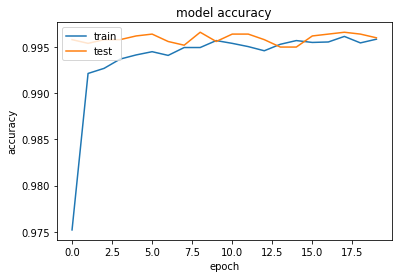

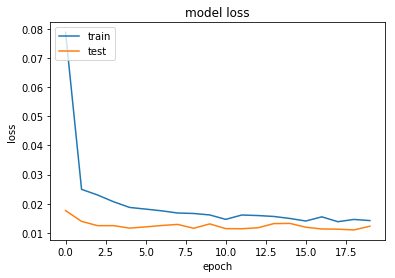

In [44]:
plot_history(history)